In [1]:
import tensorflow.compat.v1 as tf1
import os

# 환경 변수 설정
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# TensorFlow 설정
config = tf1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
session = tf1.Session(config=config)

2024-09-12 12:47:37.475772: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-12 12:47:37.520591: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-12 12:47:38.279161: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-09-12 12:47:39.465566: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 36305 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:86:00.0, compute capab

In [2]:
# 데이터 불러오기
import os
import numpy as np
import random
import shutil

train_path = "./data/Train/"
test_path = "./data/Test/"

Original Non Demented Shape: (2560, 128, 128)
Augmented Non Demented Shape: (2440, 128, 128)
Original Mild Demented Shape: (716, 128, 128)
Augmented Mild Demented Shape: (4284, 128, 128)


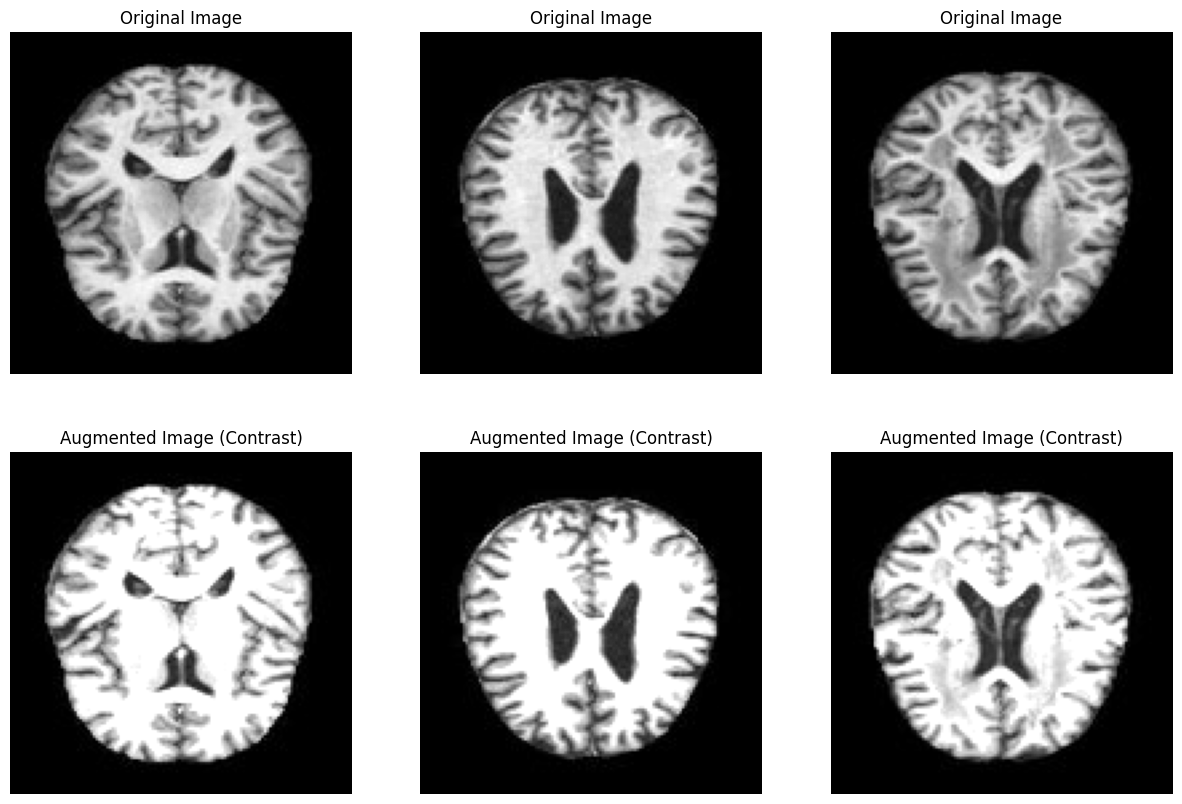

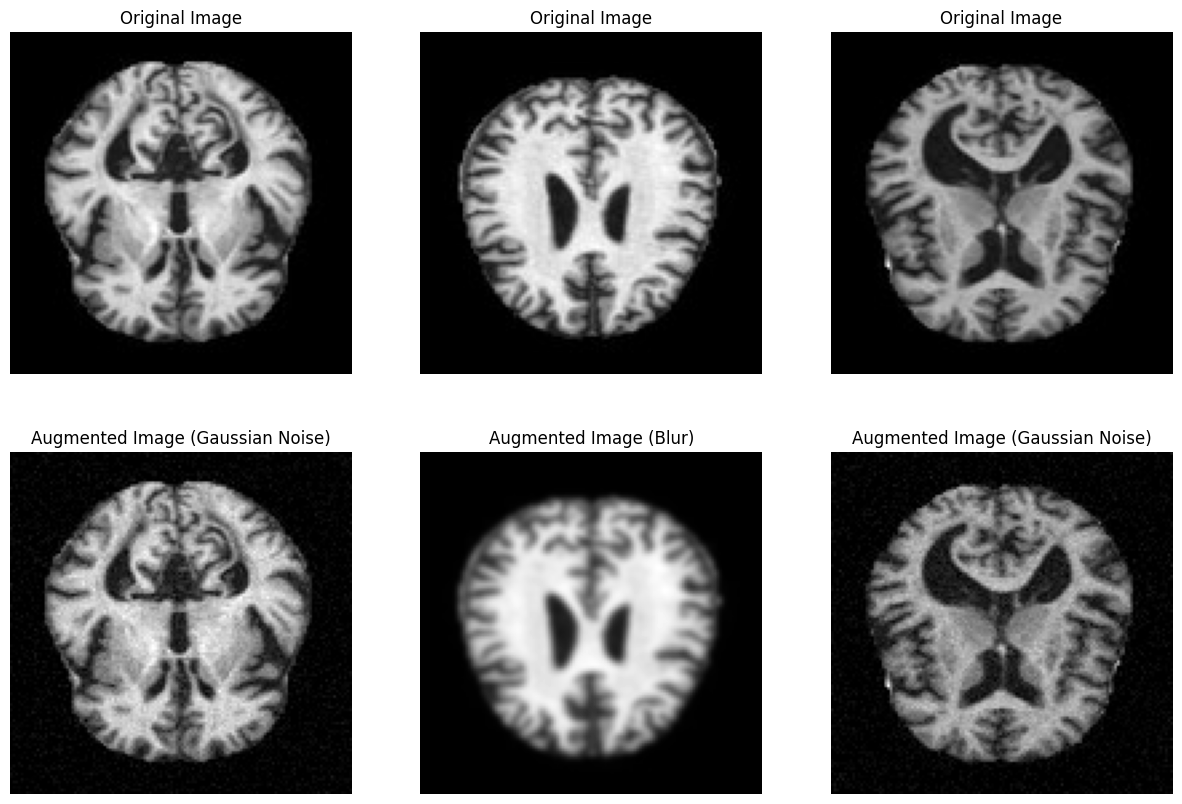

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt  # 추가: plt 임포트
import os
import random
import cv2  # OpenCV 사용

def read_images_from_path(path):
    image_files = [f for f in os.listdir(path) if f.endswith(".jpg")]
    images = [os.path.join(path, f) for f in image_files]
    return images, image_files  # 이미지 파일 이름도 반환

def add_gaussian_noise(image):
    """
    이미지에 가우시안 노이즈를 추가하는 함수.
    이미지의 값 범위(0-1 또는 0-255)를 고려하여 노이즈를 추가.
    """
    row, col = image.shape
    
    mean = 0
    var = 0.001  # 분산을 작게 설정 (너무 크면 과도한 노이즈가 추가됨)
    sigma = var ** 0.5
    
    # 노이즈 생성
    gaussian = np.random.normal(mean, sigma, (row, col))
    
    # 이미지가 0-255 범위인 경우와 0-1 범위인 경우를 다르게 처리
    if image.max() > 1:  # 이미지가 0-255 범위인 경우
        gaussian = gaussian * 255
    
    noisy_image = image + gaussian

    # 값이 0-255 또는 0-1 범위를 벗어나지 않도록 클리핑
    if image.max() > 1:
        noisy_image = np.clip(noisy_image, 0, 255)
    else:
        noisy_image = np.clip(noisy_image, 0, 1)
    
    return noisy_image


def apply_blur(image):
    """
    이미지에 블러 효과를 적용하는 함수
    """
    return cv2.GaussianBlur(image, (5, 5), 0)

def apply_contrast(image):
    """
    대비를 조정하는 함수
    """
    alpha = 1.5  # Contrast control (1.0-3.0)
    beta = 0     # Brightness control (0-100)
    contrasted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return contrasted_image

def apply_random_transformation(image):
    """
    동일한 비율로 랜덤하게 변환을 선택하여 적용하는 함수
    """
    transformations = {
        'Gaussian Noise': add_gaussian_noise,
        'Blur': apply_blur,
        'Contrast': apply_contrast
    }
    
    transformation_name = random.choice(list(transformations.keys()))  # 변환을 랜덤 선택
    transformed_image = transformations[transformation_name](image)
    
    return transformed_image, transformation_name

def images_to_numpy_with_augmentation(images, total_augmented_count):
    augmented_images = []
    original_images = []  # 원본 이미지 저장
    transformations_applied = []  # 변환 기록 저장

    num_images = len(images[0])

    # 먼저 원본 이미지를 한 번만 저장
    for i in range(num_images):
        image_path = images[0][i]
        image = mpimg.imread(image_path)
        image = image.reshape(image.shape[0], image.shape[1])  # 채널 차원 없이
        original_images.append(image)

    # 증강하고자 하는 총 이미지 수를 원본 이미지 수로 나눈 값을 구하고, 나머지가 있으면 반복하여 채움
    for i in range(total_augmented_count):
        # 이미지 인덱스는 순서대로 반복적으로 사용할 수 있도록 조정
        image_index = i % num_images
        image = original_images[image_index]

        # 랜덤 변환 적용
        augmented_image, transformation_name = apply_random_transformation(image)
        augmented_images.append(augmented_image)
        transformations_applied.append(transformation_name)  # 변환 기록 저장

    return np.array(original_images), np.array(augmented_images), transformations_applied


# Non Demented 데이터셋에서 생성할 총 증강 이미지 수
total_augmented_count_normal = 5000 - 2560 
# Mild Demented 데이터셋에서 생성할 총 증강 이미지 수
total_augmented_count_mild = 5000 - 716

# 이미지를 읽어와서 numpy 배열로 변환 후 증강
images_normal = read_images_from_path(train_path + "normal")
original_images_normal, augmented_images_normal, transformations_normal = images_to_numpy_with_augmentation(images_normal, total_augmented_count_normal)

images_mild = read_images_from_path(train_path + "mild")
original_images_mild, augmented_images_mild, transformations_mild = images_to_numpy_with_augmentation(images_mild, total_augmented_count_mild)

# 넘파이 배열의 크기 확인
print("Original Non Demented Shape:", original_images_normal.shape)
print("Augmented Non Demented Shape:", augmented_images_normal.shape)
print("Original Mild Demented Shape:", original_images_mild.shape)
print("Augmented Mild Demented Shape:", augmented_images_mild.shape)

def compare_original_and_augmented_images(original_images, augmented_images, transformations, total_augmented_count, num_images):
    """
    원본 이미지에 대응하는 하나의 증강 이미지만 출력하는 함수.
    각 원본 이미지에 대해 대응되는 첫 번째 증강 이미지를 시각화.
    """
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))  # 2행(원본 + 증강) * 3열(이미지 수)로 시각화
    
    for i in range(3):  # 처음 3개의 원본 이미지만 출력
        # 원본 이미지 출력
        ax[0, i].imshow(original_images[i].reshape(128, 128), cmap='gray')
        ax[0, i].set_title('Original Image')
        ax[0, i].axis('off')

        # 해당 원본 이미지에 대응하는 하나의 증강 이미지 출력
        augmented_index = i % len(augmented_images)  # 증강 이미지 인덱스가 초과되지 않도록 함
        ax[1, i].imshow(augmented_images[augmented_index].reshape(128, 128), cmap='gray')
        ax[1, i].set_title(f'Augmented Image ({transformations[augmented_index]})')
        ax[1, i].axis('off')

    plt.show()

# Non Demented 이미지 비교
compare_original_and_augmented_images(original_images_normal, augmented_images_normal, transformations_normal, total_augmented_count_normal, len(original_images_normal))

# Mild Demented 이미지 비교
compare_original_and_augmented_images(original_images_mild, augmented_images_mild, transformations_mild, total_augmented_count_mild, len(original_images_mild))

In [4]:
# 원본 데이터와 증강된 데이터를 합쳐서 하나의 numpy 배열로 변환
def combine_original_and_augmented(original_images, augmented_images):
    # 원본 이미지와 증강된 이미지 합치기
    combined_images = np.concatenate((original_images, augmented_images), axis=0)
    return combined_images

# Non Demented 데이터셋
numpy_array_normal = combine_original_and_augmented(original_images_normal, augmented_images_normal)

# Mild Demented 데이터셋
numpy_array_mild = combine_original_and_augmented(original_images_mild, augmented_images_mild)

# 결과 출력
print("Combined Non Demented Shape:", numpy_array_normal.shape)
print("Combined Mild Demented Shape:", numpy_array_mild.shape)

Combined Non Demented Shape: (5000, 128, 128)
Combined Mild Demented Shape: (5000, 128, 128)


In [5]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels.astype(int)]

# 각 클래스에 대한 레이블 생성
num_classes = 2  # 클래스 개수에 따라 조절
labels_normal = one_hot_encode(np.zeros(len(numpy_array_normal)), num_classes)
labels_mild = one_hot_encode(np.ones(len(numpy_array_mild)), num_classes)

# 데이터 확인
print("Non Demented Labels Shape:", labels_normal.shape)
print("Mild Demented Labels Shape:", labels_mild.shape)

# y 변수 생성
y_Non_Demented = labels_normal
y_Mild_Demented = labels_mild

Non Demented Labels Shape: (5000, 2)
Mild Demented Labels Shape: (5000, 2)


In [6]:
print(y_Non_Demented[:2])
print(y_Mild_Demented[:2])

[[1. 0.]
 [1. 0.]]
[[0. 1.]
 [0. 1.]]


In [7]:
# Non_Demented, Mild_Demented 데이터 합치기
X_train = np.concatenate((numpy_array_normal, numpy_array_mild), axis=0)

# 각 데이터에 대한 레이블 합치기
y_train = np.concatenate((y_Non_Demented, y_Mild_Demented), axis=0)

# 데이터와 레이블의 형태 확인
print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)

# 데이터와 레이블을 함께 섞기
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)

X_train = X_train[indices]
X_train = np.reshape(X_train, (-1,128,128,1))
y_train = y_train[indices]

X_train = X_train / 255.

# 섞인 데이터와 레이블의 형태 확인
print("Shuffled X_train Shape:", X_train.shape)
print("Shuffled y_train Shape:", y_train.shape)

X_train Shape: (10000, 128, 128)
y_train Shape: (10000, 2)
Shuffled X_train Shape: (10000, 128, 128, 1)
Shuffled y_train Shape: (10000, 2)


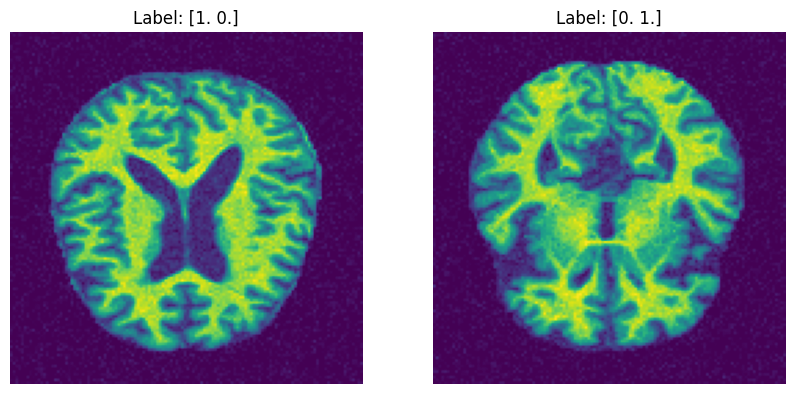

In [8]:
import matplotlib.pyplot as plt
# 원하는 레이블에 해당하는 이미지 무작위로 선택
desired_labels = np.array([[1, 0], [0, 1]])
selected_images = []
selected_labels = []

for label in desired_labels:
    # 해당 레이블에 해당하는 인덱스 추출
    indices = np.where((y_train == label).all(axis=1))[0]
    
    # 해당 인덱스 중 무작위로 1개 선택
    random_index = np.random.choice(indices, 1)[0]
    
    # 이미지 및 레이블 저장
    selected_images.append(X_train[random_index])
    selected_labels.append(y_train[random_index])

# 선택한 이미지 플로팅
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i in range(2):
    axes[i].imshow(selected_images[i])
    axes[i].set_title(f"Label: {selected_labels[i]}")
    axes[i].axis('off')

plt.show()

In [9]:
import matplotlib.image as mpimg

def read_images_from_path(path):
    image_files = [f for f in os.listdir(path) if f.endswith(".jpg")]
    images = [os.path.join(path, f) for f in image_files]
    return images

def images_to_numpy(images):
    image_arrays = [mpimg.imread(image_path) for image_path in images]
    return np.array(image_arrays)

# 각 경로에서 모든 이미지를 읽어와서 numpy 배열로 변환
images_normal = read_images_from_path(test_path + "normal")
numpy_array_normal = images_to_numpy(images_normal)

images_mild = read_images_from_path(test_path + "mild")
numpy_array_mild = images_to_numpy(images_mild)

# 각 클래스에 대한 레이블 생성
num_classes = 2  # 클래스 개수에 따라 조절
labels_normal = one_hot_encode(np.zeros(len(numpy_array_normal)), num_classes)
labels_mild = one_hot_encode(np.ones(len(numpy_array_mild)), num_classes)

# y 변수 생성
y_Non_Demented = labels_normal
y_Mild_Demented = labels_mild

# Moderate_Demented, Non_Demented, Very_Mild_Demented 데이터 합치기
X_test = np.concatenate((numpy_array_normal, numpy_array_mild), axis=0)

# 각 데이터에 대한 레이블 합치기
y_test = np.concatenate((y_Non_Demented, y_Mild_Demented), axis=0)

# 데이터와 레이블의 형태 확인
print("X_train Shape:", X_test.shape)
print("y_train Shape:", y_test.shape)

# 데이터와 레이블을 함께 섞기
indices = np.arange(X_test.shape[0])
np.random.shuffle(indices)

X_test = X_test[indices]
X_test = np.reshape(X_test, (-1,128,128,1))
X_test = X_test / 255.
y_test = y_test[indices]

# 섞인 데이터와 레이블의 형태 확인
print("Shuffled X_test Shape:", X_test.shape)
print("Shuffled y_test Shape:", y_test.shape)

X_train Shape: (820, 128, 128)
y_train Shape: (820, 2)
Shuffled X_test Shape: (820, 128, 128, 1)
Shuffled y_test Shape: (820, 2)


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# F1 Score를 저장할 리스트
f1_scores_train = []
f1_scores_test = []

for i in range(5):
    # 모델 초기화 및 정의
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(2, activation='softmax')  # 클래스 개수에 맞춰 조절
    ])
    
    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # 데이터 학습
    model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2, verbose=0)
    
    # 훈련 데이터 예측 및 F1 스코어 계산
    y_pred_train = model.predict(X_train)
    y_pred_labels_train = np.argmax(y_pred_train, axis=1)
    y_true_labels_train = np.argmax(y_train, axis=1)
    f1_train = f1_score(y_true_labels_train, y_pred_labels_train, average='weighted')
    f1_scores_train.append(f1_train)
    
    # 테스트 데이터 예측 및 F1 스코어 계산
    y_pred_test = model.predict(X_test)
    y_pred_labels_test = np.argmax(y_pred_test, axis=1)
    y_true_labels_test = np.argmax(y_test, axis=1)
    f1_test = f1_score(y_true_labels_test, y_pred_labels_test, average='weighted')
    f1_scores_test.append(f1_test)
    
    # 각 실험의 F1 Score 출력
    print(f"Experiment {i+1} - Train F1 Score: {f1_train:.8f}, Test F1 Score: {f1_test:.8f}")

# 훈련 데이터 F1 스코어의 평균과 표준편차
f1_mean_train = np.mean(f1_scores_train)
f1_std_train = np.std(f1_scores_train)

# 테스트 데이터 F1 스코어의 평균과 표준편차
f1_mean_test = np.mean(f1_scores_test)
f1_std_test = np.std(f1_scores_test)

# F1 스코어 배열 형식으로 출력
print("\nTest Data F1 Scores (Array Format):")
print(f1_scores_test)

# 결과 출력
print("\nFinal Results:")
print(f"Training Data - F1 Score Mean: {f1_mean_train:.8f}, Std: {f1_std_train:.8f}")
print(f"Test Data - F1 Score Mean: {f1_mean_test:.8f}, Std: {f1_std_test:.8f}")

2024-09-12 12:47:46.689836: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 36305 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:86:00.0, compute capability: 8.0
2024-09-12 12:47:49.253005: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-09-12 12:47:49.374828: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-09-12 12:47:49.595798: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-09-12 12:47:49.621156: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f65a370cbe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-12 12:47:49.621183: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0

26/26 [==============================] - 0s 9ms/step
Experiment 1 - Train F1 Score: 1.00000000, Test F1 Score: 0.99263799
26/26 [==============================] - 0s 4ms/step
Experiment 2 - Train F1 Score: 1.00000000, Test F1 Score: 0.99756098
26/26 [==============================] - 0s 4ms/step
Experiment 3 - Train F1 Score: 0.99980000, Test F1 Score: 0.99512195
26/26 [==============================] - 0s 4ms/step
Experiment 4 - Train F1 Score: 1.00000000, Test F1 Score: 0.99269741
26/26 [==============================] - 0s 5ms/step
Experiment 5 - Train F1 Score: 0.99990000, Test F1 Score: 0.99634510

Test Data F1 Scores (Array Format):
[0.9926379871121378, 0.9975609756097561, 0.9951219512195122, 0.9926974143292129, 0.9963451004065983]

Final Results:
Training Data - F1 Score Mean: 0.99994000, Std: 0.00008000
Test Data - F1 Score Mean: 0.99487269, Std: 0.00195871


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import f1_score

# F1 Score를 저장할 리스트
f1_scores_train = []
f1_scores_test = []

for i in range(5):
    # VGG16 유사 모델 정의
    model = models.Sequential([
        # 첫 번째 컨볼루션 블록
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),

        # 두 번째 컨볼루션 블록
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),

        # 세 번째 컨볼루션 블록
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),

        # 네 번째 컨볼루션 블록
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),

        # 다섯 번째 컨볼루션 블록
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),

        # 분류기
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dense(4096, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.00005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # 데이터 학습, 로그 출력 비활성화
    model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2, verbose=0)
    
    # 훈련 데이터 예측 및 F1 스코어 계산
    y_pred_train = model.predict(X_train)
    y_pred_labels_train = np.argmax(y_pred_train, axis=1)
    y_true_labels_train = np.argmax(y_train, axis=1)
    f1_train = f1_score(y_true_labels_train, y_pred_labels_train, average='weighted')
    f1_scores_train.append(f1_train)
    
    # 테스트 데이터 예측 및 F1 스코어 계산
    y_pred_test = model.predict(X_test)
    y_pred_labels_test = np.argmax(y_pred_test, axis=1)
    y_true_labels_test = np.argmax(y_test, axis=1)
    f1_test = f1_score(y_true_labels_test, y_pred_labels_test, average='weighted')
    f1_scores_test.append(f1_test)
    
    # 각 실험의 F1 Score 출력
    print(f"Experiment {i+1} - Train F1 Score: {f1_train:.8f}, Test F1 Score: {f1_test:.8f}")

# 훈련 데이터 F1 스코어의 평균과 표준편차
f1_mean_train = np.mean(f1_scores_train)
f1_std_train = np.std(f1_scores_train)

# 테스트 데이터 F1 스코어의 평균과 표준편차
f1_mean_test = np.mean(f1_scores_test)
f1_std_test = np.std(f1_scores_test)

# F1 스코어 배열 형식으로 출력
print("\nTest Data F1 Scores (Array Format):")
print(f1_scores_test)

# 결과 출력
print("\nFinal Results:")
print(f"Training Data - F1 Score Mean: {f1_mean_train:.8f}, Std: {f1_std_train:.8f}")
print(f"Test Data - F1 Score Mean: {f1_mean_test:.8f}, Std: {f1_std_test:.8f}")

26/26 [==============================] - 1s 21ms/step
Experiment 1 - Train F1 Score: 0.98449628, Test F1 Score: 0.96881394
26/26 [==============================] - 0s 9ms/step
Experiment 2 - Train F1 Score: 1.00000000, Test F1 Score: 0.99511213
26/26 [==============================] - 0s 9ms/step
Experiment 3 - Train F1 Score: 0.99980000, Test F1 Score: 0.99393225
26/26 [==============================] - 0s 9ms/step
Experiment 4 - Train F1 Score: 1.00000000, Test F1 Score: 0.99634510
26/26 [==============================] - 0s 9ms/step
Experiment 5 - Train F1 Score: 0.99970000, Test F1 Score: 0.99755607

Test Data F1 Scores (Array Format):
[0.9688139409605888, 0.9951121304151798, 0.9939322471387485, 0.9963451004065983, 0.9975560652075898]

Final Results:
Training Data - F1 Score Mean: 0.99679926, Std: 0.00615259
Test Data - F1 Score Mean: 0.99035190, Std: 0.01083680
